In [2]:
import pandahouse as ph
from scipy import stats
import seaborn as sns

## Коннектимся к ClickHouse

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250620feed_actions'
}

In [4]:
query = "SELECT * FROM simulator_20250620.feed_actions LIMIT 10"
df = ph.read_clickhouse(query, connection=connection)
df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,106791,76,view,2025-05-03 00:26:19,0,45,Russia,Chelyabinsk,iOS,ads,3
1,659,76,view,2025-05-03 00:26:31,0,30,Russia,Partizansk,Android,ads,0
2,106791,76,like,2025-05-03 00:27:59,0,45,Russia,Chelyabinsk,iOS,ads,3
3,695,76,view,2025-05-03 00:29:39,1,27,Russia,Engels,Android,ads,0
4,695,76,like,2025-05-03 00:29:51,1,27,Russia,Engels,Android,ads,0
5,614,76,view,2025-05-03 00:32:01,0,38,Russia,Nizhnevartovsk,iOS,ads,0
6,614,76,like,2025-05-03 00:32:56,0,38,Russia,Nizhnevartovsk,iOS,ads,0
7,223,76,view,2025-05-03 00:34:02,1,19,Ukraine,Chernihiv,Android,ads,3
8,952,76,view,2025-05-03 00:36:34,0,24,Russia,Moscow,Android,ads,0
9,952,76,like,2025-05-03 00:36:55,0,24,Russia,Moscow,Android,ads,0


## A/B Тест

#### Подсчет наблюдений для АВ-теста (1-контрольной и 2 - тестовой группы)

In [4]:
query = """
SELECT exp_group,
       COUNT(distinct user_id)
FROM simulator_20250620.feed_actions
WHERE time::date between '2025-05-30' and '2025-06-05'
  and exp_group in (1, 2)
GROUP BY exp_group
"""
count_group = ph.read_clickhouse(query, connection=connection)
count_group

,exp_group,uniqExact(user_id)
0,1,10020
1,2,9877


#### Создание датасета с CTR по кликам/просмотрам по группам АВ

In [5]:
query = """
SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
 FROM simulator_20250620.feed_actions 
WHERE time::date between '2025-05-30' and '2025-06-05'
  and exp_group in (1, 2)
GROUP BY exp_group, user_id
ORDER BY exp_group
"""

df_ctr = ph.read_clickhouse(query, connection=connection)
df_ctr

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19892,2,16512,13,79,0.164557
19893,2,17146,0,10,0.000000
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


#### Построение графика распределения CTR по группам АВ

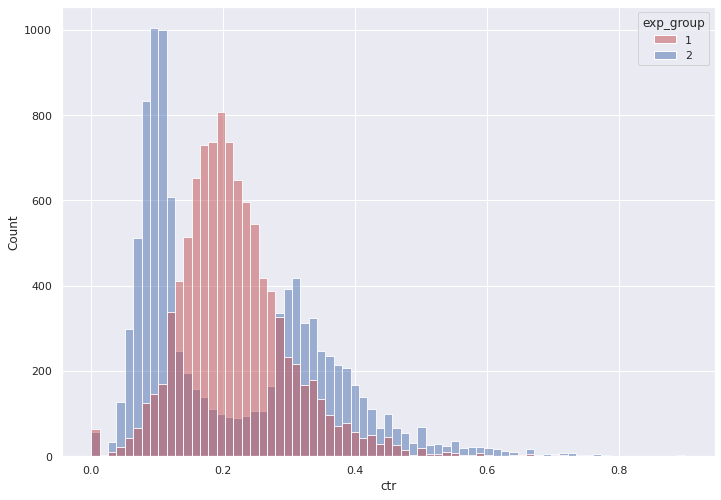

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df_ctr, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Описание:\
Группы A и В по кличеству примерно совпадают, по распредлению CRT нет:\
        1-ая группа имеет один горб\
        2-ая группа имеем 2 горба\
        \
 Вывод:\
 1)Распределения 2-ой группы не нормально, однако согласно ЦПТ это не важно, главное, чтобы выборочные средние распределелись нормальным образом, что точно будет согласно ЦПТ при n>30 (лучше n>200), у нас n> 9000\
 PS (Для CRT рекомендовано использовать метод ХИ квадрат)\
 2)Следовательно можно использовать ТТест

#### Построение графика распределения просмотров по группам АВ (есть ли влияние эксперимента на просмотры)

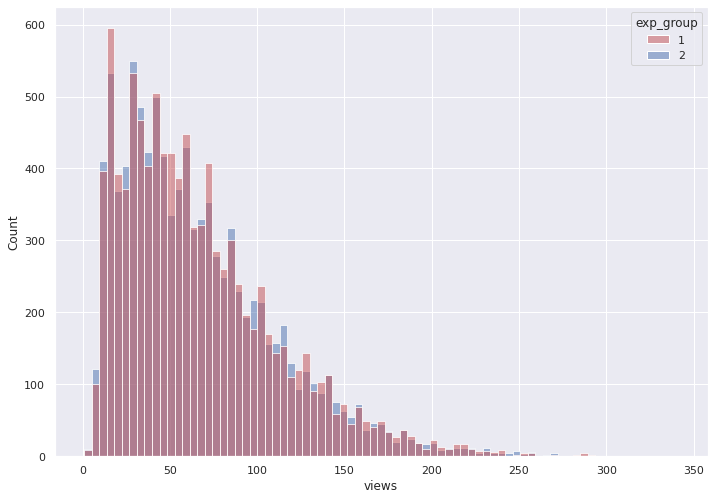

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df_ctr, 
              x='views', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Вывод: эксперимент не влияет на просмотры

#### ТТест для CTR по группам АВ
H0 - у групп АВ CTR не различается стат значимо\
H1 - у групп АВ CTR различается стат значимо\
a = 0.05\
(1-контрольная 2 - тестовая группы)

##### Pandas

In [147]:
stats.ttest_ind(df_ctr[df_ctr.exp_group == 1].ctr,
                df_ctr[df_ctr.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Вывод: p_Value > 0.05 => H0 не отклоняем 

##### ClickHouse (в целях отработки изученного материала)

In [9]:
query = """
WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20250620.feed_actions 
    WHERE time::date between '2025-05-30' and '2025-06-05'
      and exp_group in (1, 2)
    GROUP BY exp_group, user_id)
"""
ph.read_clickhouse(query, connection=connection)

,statistic,p_value
0,0.405149,0.685373


Вывод: получили такой же результат как и через pandas

#### Вывод: По ТТесту p_Value > 0.05 => H0 не отклоняем 

#### Тест Манна_Уитни для CTR по группам АВ 
H0 - P(X>Y) = P(Y>X)  X ∈ А группе, Y ∈ В группе\
H1 - P(X>Y) != P(Y>X) X ∈ А группе, Y ∈ В группе\
a = 0.05\
(1-контрольная 2 - тестовая группы)

##### Pandas

In [148]:
stats.mannwhitneyu(df_ctr[df_ctr.exp_group == 1].ctr,
                df_ctr[df_ctr.exp_group == 2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Вывод: p_Value < 0.05 => H0 отклоняем и P(X>Y) != P(Y>X) X ∈ А группе, Y ∈ В группе

##### ClickHouse (в целях отработки изученного материала)

In [42]:
query = """

WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20250620.feed_actions 
    WHERE time::date between '2025-05-30' and '2025-06-05'
      and exp_group in (1, 2)
    GROUP BY exp_group, user_id)
"""
ph.read_clickhouse(query, connection=connection)

,statistic,p_value
0,55189913.0,3.148592e-13


Вывод: получили такой же результат как и через pandas

#### Вывод: По тесту Манна_Уитни p_Value < 0.05 => H0 отклоняем и P(X>Y) != P(Y>X) X ∈ А группе, Y ∈ В группе

#### Процедура сглаживанием Лапласа CTR
(Когда просмотров много, сглаженный CTR почти равен CTR пользователя.\
Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR)

In [48]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [49]:
query = """
SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
 FROM simulator_20250620.feed_actions 
WHERE time::date between '2025-05-30' and '2025-06-05'
  and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""
df_ctr = ph.read_clickhouse(query, connection=connection)
df_ctr

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19892,1,132567,52,326,0.159509
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [50]:
global_ctr_1 = df_ctr[df_ctr.exp_group == 1].likes.sum()/df_ctr[df_ctr.exp_group == 1].views.sum()
global_ctr_2 = df_ctr[df_ctr.exp_group == 2].likes.sum()/df_ctr[df_ctr.exp_group == 2].views.sum()

In [51]:
global_ctr_1

0.2096041628394293

In [52]:
global_ctr_2

0.20025051027061783

##### Построение графика распределения CTR по группам АВ

/tmp/ipykernel_49/366956538.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr,


<Axes: xlabel='ctr'>

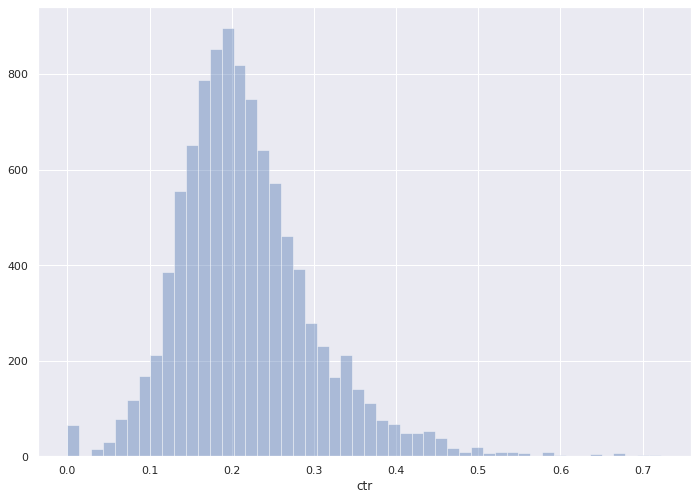

In [53]:
group1 = df_ctr[df_ctr.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)

In [56]:
group1

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19886,1,31540,7,39,0.179487
19887,1,23359,12,32,0.375000
19890,1,110956,3,16,0.187500
19892,1,132567,52,326,0.159509


/tmp/ipykernel_49/3184982969.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.ctr,


<Axes: xlabel='ctr'>

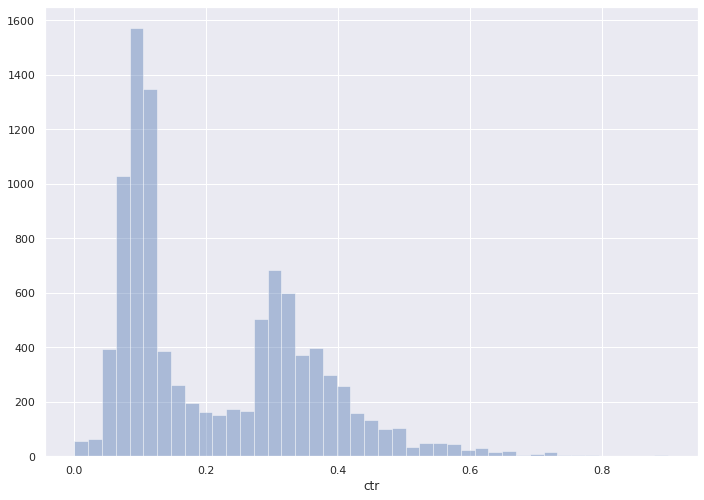

In [54]:
group2 = df_ctr[df_ctr.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

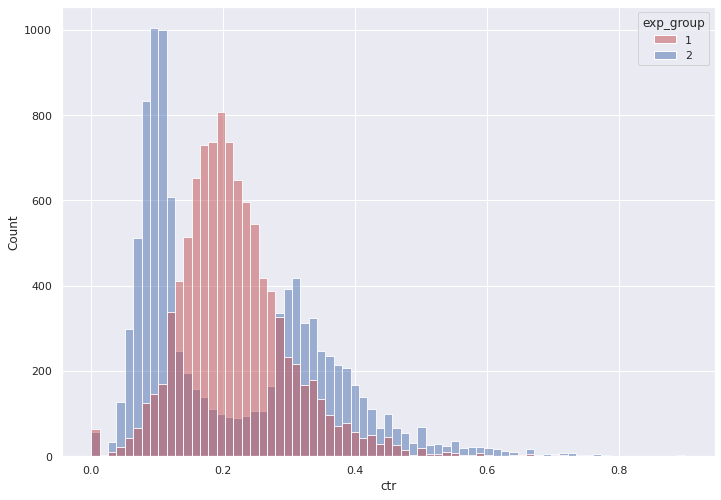

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df_ctr, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

##### Построение графика распределения  сглаженного CTR по группам АВ

In [58]:
group1['smothed_ctr'] = df_ctr.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [59]:
group2['smothed_ctr'] = df_ctr.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

/tmp/ipykernel_49/1232089014.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

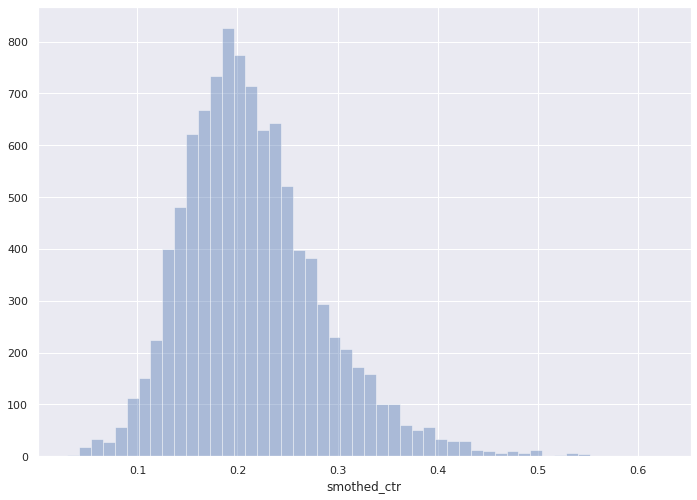

In [60]:
sns.distplot(group1.smothed_ctr, 
             kde = False)

/tmp/ipykernel_49/2330985544.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

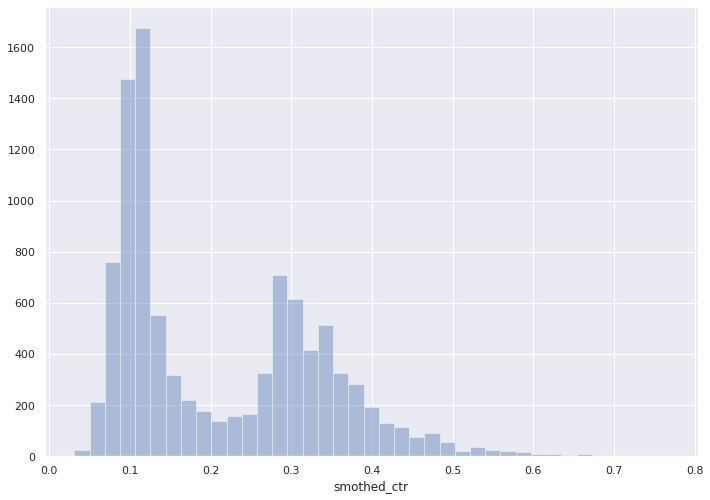

In [61]:
sns.distplot(group2.smothed_ctr, 
             kde = False)

##### ТТест для сглаженных CTR по группам АВ
H0 - у групп АВ CTR не различается стат значимо\
H1 - у групп АВ CTR различается стат значимо\
a = 0.05\
(1-контрольная 2 - тестовая группы)

In [64]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

#### Вывод: По ТТесту для сглаженного СTR p_Value > 0.05 => H0 не отклоняем
Однако для сглаженного CTR pValue меньше, чем для обычного CTR => в обычном CTR встречаются зашумленные наблюдения

#### Пуассоновский бутстреп

##### 1-ый вариант

In [36]:
import numpy as np
from scipy.stats import poisson

In [37]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [38]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250620.feed_actions
WHERE time::date between '2025-05-30' and '2025-06-05'
  and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df_ctr_poisson = ph.read_clickhouse(q, connection=connection)

In [39]:
likes1 = df_ctr_poisson.query('exp_group == 1').likes.to_numpy()
views1 = df_ctr_poisson.query('exp_group == 1').views.to_numpy()
likes2 = df_ctr_poisson.query('exp_group == 2').likes.to_numpy()
views2 = df_ctr_poisson.query('exp_group == 2').views.to_numpy()

In [40]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

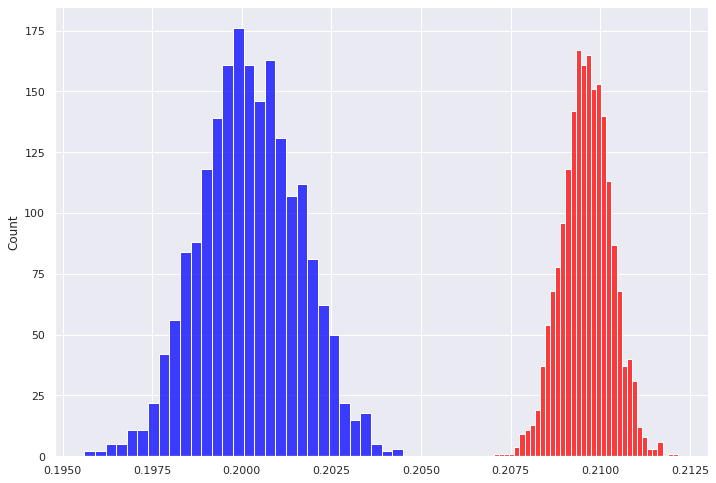

In [44]:
sns.histplot(ctr1, color='red')
sns.histplot(ctr2, color='blue')

<Axes: ylabel='Count'>

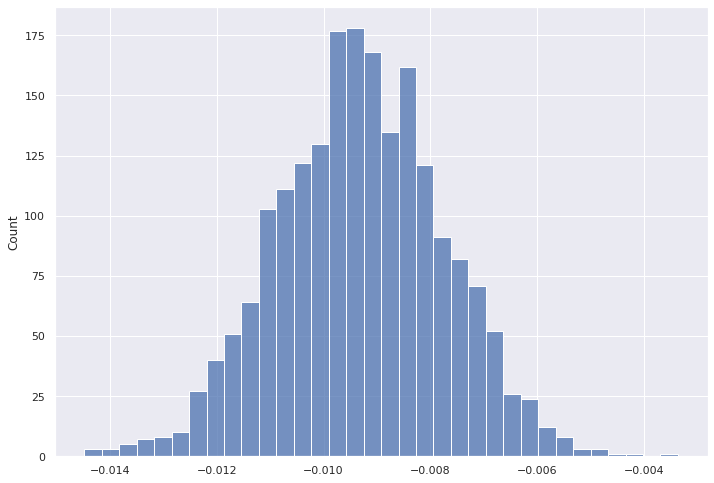

In [112]:
sns.histplot(ctr2 - ctr1)

Вывод: По Пуассоновскому бутстрапу CTR 1 и 2 группы имеют стат значимые различия

##### 2-ой вариант

In [134]:
def poisson_bootstrap_ctr_dc(likes1, views1, likes2, views2, n_bootstrap=2000):
    ctr_diff_list = []
    ctr_a_list = []
    ctr_b_list = []
    for _ in range(n_bootstrap):
        weights_a = poisson.rvs(mu=1, size=len(likes1))
        weights_b = poisson.rvs(mu=1, size=len(likes2))
        
        boot_likes_a = np.sum(likes1 * weights_a)
        boot_views_a = np.sum(views1 * weights_a)
        boot_likes_b = np.sum(likes2 * weights_b)
        boot_views_b = np.sum(views2 * weights_b)
        
        ctr_a = boot_likes_a / boot_views_a #if boot_views_a > 0 else 0
        ctr_b = boot_likes_b / boot_views_b #if boot_views_b > 0 else 0
        
        ctr_diff_list.append(ctr_a - ctr_b)
        ctr_a_list.append(ctr_a)
        ctr_b_list.append(ctr_b)
    
    return ctr_a_list, ctr_b_list, ctr_diff_list

In [135]:
ctr1_2var, ctr2_2var, diff_ctr_2var = poisson_bootstrap_ctr_dc(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

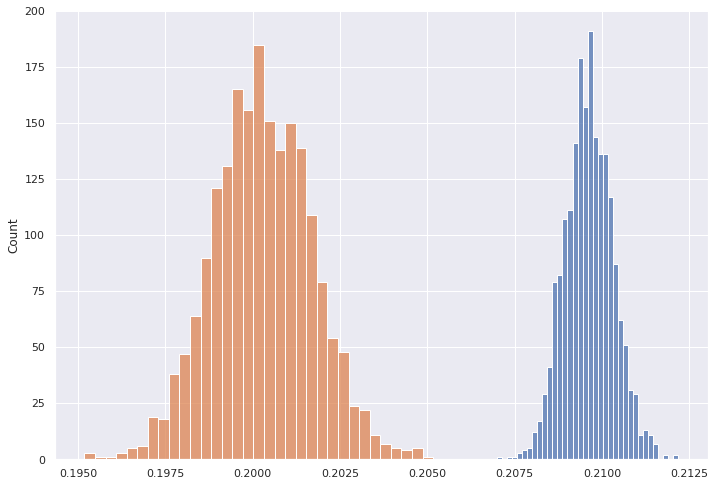

In [136]:
sns.histplot(ctr1_2var)
sns.histplot(ctr2_2var)

<Axes: ylabel='Count'>

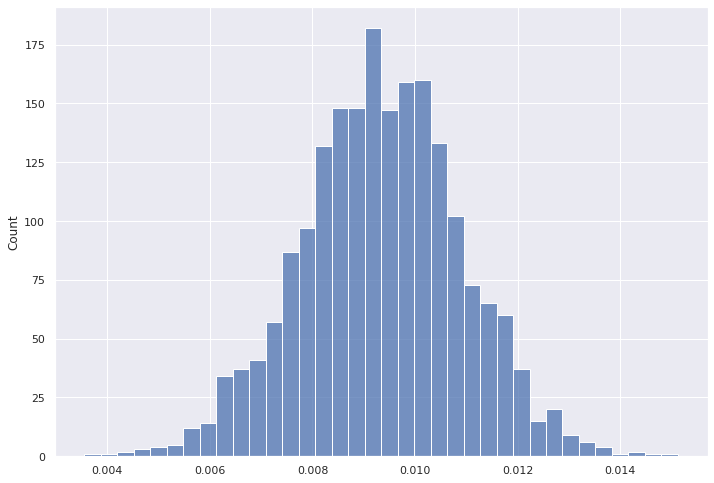

In [137]:
sns.histplot(diff_ctr_2var)

Вывод: 2 и 1 варианты идентичны

##### Проведем ттест по данным, полученным из пуассоновского бутстрапа
H0 - у групп АВ CTR не различается стат значимо\
H1 - у групп АВ CTR различается стат значимо\
a = 0.05\
(1-контрольная 2 - тестовая группы)

In [150]:
stats.ttest_ind(ctr1_2var,
                ctr2_2var,
                equal_var=False)

Ttest_indResult(statistic=263.68715861661866, pvalue=0.0)

#### Вывод: По ттесту после Пуассоновского бутстрапа CTR 1 и 2 группы имеют стат значимые различия, что было уже понятно из того, что гистограммы не пересеклись

#### Бакетирование + ТТест

In [45]:
query = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%500 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20250620.feed_actions 
    WHERE time::date between '2025-05-30' and '2025-06-05'
      and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(query, connection=connection)

In [46]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.306277820839115, pvalue=1.485397822029051e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

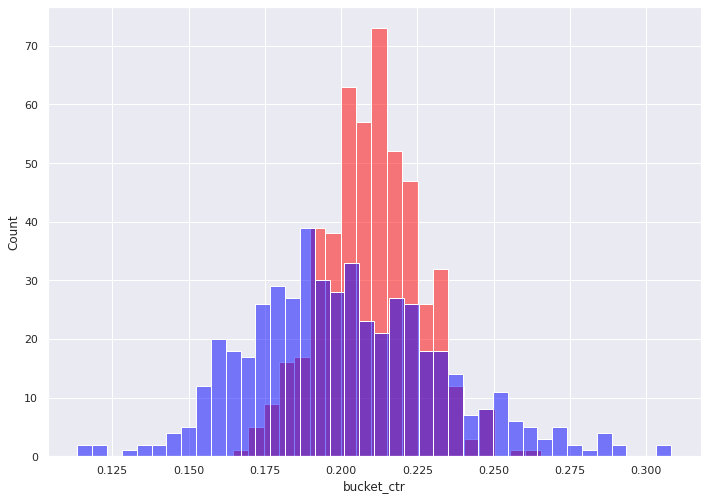

In [53]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr, color = 'red', bins=20, alpha=0.5)
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr, color = 'blue',bins=40, alpha=0.5)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

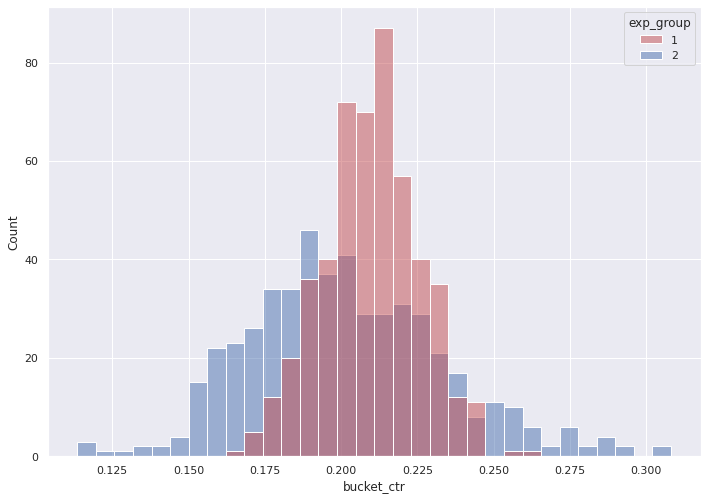

In [48]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#groups = 
sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              #alpha=0.5,
              #kde=False
            )

#### Вывод: По ттесту после Бакетирования CTR 1 и 2 группы имеют стат значимые различия, pvalue < 0.05

#### Линеризация + ТТест

In [6]:
query = """
SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
 FROM simulator_20250620.feed_actions 
WHERE time::date between '2025-05-30' and '2025-06-05'
  and exp_group in (1, 2)
GROUP BY exp_group, user_id
ORDER BY exp_group
"""

df_ctr = ph.read_clickhouse(query, connection=connection)
df_ctr.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [9]:
Global_CTR_control_group = df_ctr.query('exp_group == 1').likes.sum()/df_ctr.query('exp_group == 1').views.sum()
Global_CTR_control_group

0.2096041628394293

In [10]:
df_ctr['linearize_metric'] = df_ctr['likes'] - Global_CTR_control_group*df_ctr['views']

In [13]:
stats.ttest_ind(df_ctr.query('exp_group == 1').linearize_metric,
                df_ctr.query('exp_group == 2').linearize_metric,
                equal_var = False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)

#### Вывод: p_Value < 0.05 => H0 отклоняем (стат значимые различия есть)
statistic > 0 => CTR 1 > CTR 2

## Выводы A/B Тест:

Мы применили множество методов для сравнения двух групп, краткие результаты ниже: \
1 группа - контрольная (около нормальное распределение - 1 горб)\
2 группа - тестовая (не нормальное распределение сырых данных - 2 горба)\
\
(ЦПТ не запрещает нам использовать Ттест Стьюдента, тк количество наблюдений в каждой группе около 10000 => распределение сырых данных не обязательно должно быть нормальным)

- Ттест Стьюдента на сырых данных:     p_Value > 0.05 => H0 не отклоняем (H0 - у групп АВ CTR не различается стат значимо). Как следуюет из статьи(https://docs.google.com/document/d/19dupja76VvA_z5N-j-LDZB9givEBPbtS1KHCE7sJo9E/edit?tab=t.0) при сильной ассиметрии распределения мы можем использовать ттест, но мощность теста при этом снижается, в результате чего и у нас получились результаты отличные от непараметрических тестов ниже.
- Тест Манна-Уитни на сырых данных:    p_Value < 0.05 => H0 отклоняем  (P(X>Y) != P(Y>X) X ∈ А группе, Y ∈ В группе). Тест сложно интерпритируем, однако при сильной ассиметрии распределения он по мощности превосхожит ттест, поэтому может дать более корректный результат.
- Процедура сглаживанием Лапласа CTR:  p_Value > 0.05 => H0 не отклоняем (По ТТесту для сглаженного СTR).
Однако для сглаженного CTR pValue меньше, чем для обычного CTR => в обычном CTR встречаются зашумленные наблюдения
- Пуассоновский бутстреп: p_Value = 0 (По ТТесту СTR после Пуассоновского бутстрапа) + графики разниц CTR 1 и 2 группы не пересекаются => CTR 1 и 2 группы имеют стат значимые различия **CTR 2 группы меньше, чем CTR 1 группы**
- Бакетирование: p_Value < 0.05 => H0 отклоняем (По ТТесту после бакетирования СTR) **CTR 2 группы меньше, чем CTR 1 группы**
- Линеризация: p_Value < 0.05 => H0 отклоняем (По ТТесту после линеризации) **CTR 2 группы меньше, чем CTR 1 группы**
\
**Новый алгоритм не внедряем, с ним показатели хуже**